In [ ]:
I # Checking whether kaolin is installed,If it is not installing it
need_kaolin=False
try:
  import kaolin as kal
except ModuleNotFoundError:
  need_kaolin=True
if need_kaolin:
  !pip install git+https://github.com/NVIDIAGameWorks/kaolin

  Cloning https://github.com/NVIDIAGameWorks/kaolin to /tmp/pip-req-build-ggg8rvoh
  Running command git clone -q https://github.com/NVIDIAGameWorks/kaolin /tmp/pip-req-build-ggg8rvoh
     |████████████████████████████████| 776.7MB 22kB/s 
     |████████████████████████████████| 2.2MB 44.1MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 22.9MB 1.4MB/s 
  Created wheel for kaolin: filename=kaolin-0.9.0-cp36-cp36m-linux_x86_64.whl size=14662660 sha256=2497a109631c400fea3831d3a88a0b2dd69156c0af30bc30bc753ec80037d67a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bh994z1g/wheels/15/c4/65/ae464259deb4025e30d12c79aa8a557dc7208121a6047d8dd0
Successfully built kaolin
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installa

In [ ]:
# Importing auxillary libraries 
import os
import sys
import torch

# Checking whether pytorch3d is installed,If it is not installing it
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py36_cu102_pyt170/download.html
     |████████████████████████████████| 31.6MB 111kB/s 
     |████████████████████████████████| 645kB 12.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210213-cp36-none-any.whl size=44977 sha256=fc0bc90702ddbb01cf660b5c7b412317af0cccfb7bc6be9cae95336be1b934b1
  Stored in directory: /root/.cache/pip/wheels/6e/13/17/51fc28081c91c309faaedf03bf2077a004d887fb66156c45e3
  Created wheel for iopath: filename=iopath-0.1.3-cp36-none-any.whl size=11169 sha256=53942146b73680096c4588a6901ff801c8c3fad944ca14eecb4df0dbf4cc2f5b
  Stored in directory: /root/.cache/pip/wheels/a9/1d/55/94a55e032409ac7617f9cbb88a0fa2cf4e7208806c29730804
Successfully built fvcore iopath
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Importing libraries needed
from matplotlib import pyplot as plt
from kaolin import render,ops,io,metrics
from pytorch3d.io import load_objs_as_meshes, load_obj

In [ ]:
def render_image_array(file_name, camera_position, camera_up_dir = torch.tensor([[0.,-1.,0.]]),fovyangle = 30):

  '''Gives a numpy array that can 
    Args:
        file_name (str or Path): obj file path
        camera_position (torch.FloatTensor): camera positions of shape (batch_size,3), it means where your cameras are
        camera_up_dir (torch.FloatTensor): camera up directions of shape (batch_size,3), it means what are your camera up directions 
        fovyangle (float): field of view angle of y axis'''

  # Load obj file and extracting faces & vertices
  try:

    mesh=io.obj.import_mesh(file_name ,with_materials=False ,with_normals=True)

    vertices = mesh.vertices.unsqueeze(0).cuda()

    faces = mesh.faces.cuda()
  
  #kaolin only supports obj files having faces with three vertices, so incase if we have
  #more more vertices per face load_objs_as_meshes from pytorch3d is used to load obj files 
  except ValueError:

    mesh = load_objs_as_meshes([file_name], device='cuda')
    
    vertices = mesh.verts_packed().unsqueeze(0)
    

    faces = mesh.faces_packed()

  camera_position = camera_position.cuda()

  camera_up_dir = camera_up_dir.cuda()

  # Postion at which camera should point
  look_at = vertices.mean(dim=1)[0]

  print(look_at)

  # Generating rotation and transaltion matrices 
  camera_rot , camera_trans = render.camera.generate_rotate_translate_matrices(camera_position, look_at, camera_up_dir)

  # Generating camera projection based on field of view angle
  camera_proj = render.camera.generate_perspective_projection(fovyangle, ratio=1.0, dtype=torch.float32).cuda()

  # Projecting vertices and other features to camera's view
  face_vertices_z = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[0][:,:,:,2]
  face_vertices_image = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[1]
  face_normals_z = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[2][:,:,2]

  #Index vertex features to convert per vertex tensor to per vertex per face tensor.
  face_features = ops.mesh.index_vertices_by_faces(vertices, faces)

  #Renders 3D triangle meshes with per-vertex per-face features to generalized feature “images”,
  #soft foreground masks, depth and face index maps.
  rendered = render.mesh.dibr_rasterization(512, 512, face_vertices_z, face_vertices_image, face_features, face_normals_z) 
  
  #Rendered image
  rendered_image_arr = rendered[0].squeeze(0).squeeze(2).cpu().numpy()

  return rendered_image_arr

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:531: UserWarning: Mtl file does not exist: /content/drive/MyDrive/render_assignment/SSS_061.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-3.2704, 49.7224,  7.2224], device='cuda:0')


Text(0.5, 1.0, 'Sofa 1 front view')

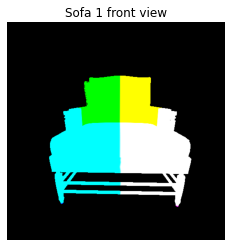

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_01.obj',torch.tensor([[0.,80.,130.]])))
plt.axis('off')
plt.title('Sofa 1 front view')

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:531: UserWarning: Mtl file does not exist: /content/drive/MyDrive/render_assignment/SSS_061.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-3.2704, 49.7224,  7.2224], device='cuda:0')


Text(0.5, 1.0, 'Sofa 1 right view')

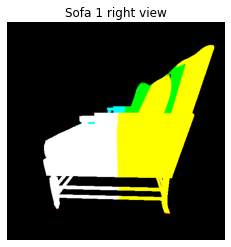

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_01.obj',torch.tensor([[120.,80.,-7.2224]])))
plt.axis('off')
plt.title('Sofa 1 right view')

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:531: UserWarning: Mtl file does not exist: /content/drive/MyDrive/render_assignment/SSS_061.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-3.2704, 49.7224,  7.2224], device='cuda:0')


Text(0.5, 1.0, 'Sofa 1 left view')

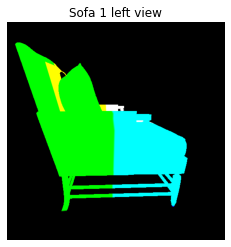

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_01.obj',torch.tensor([[-120.,80.,-7.2224]])))
plt.axis('off')
plt.title('Sofa 1 left view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.3196, 50.5907, -9.3428], device='cuda:0')


Text(0.5, 1.0, 'Sofa 2 front view')

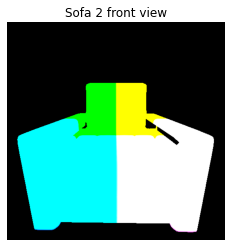

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_02.obj',torch.tensor([[-0.3196,85.,130.]])))
plt.axis('off')
plt.title('Sofa 2 front view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.3196, 50.5907, -9.3428], device='cuda:0')


Text(0.5, 1.0, 'Sofa 2 right view')

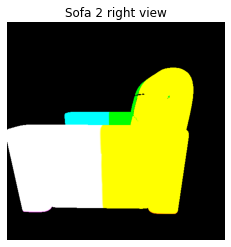

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_02.obj',torch.tensor([[135.,85.,-10.]],device='cuda')))
plt.axis('off')
plt.title('Sofa 2 right view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.3196, 50.5907, -9.3428], device='cuda:0')


Text(0.5, 1.0, 'Sofa 2 left view')

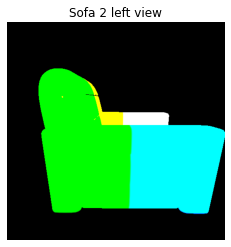

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_02.obj',torch.tensor([[-135.,85.,-10.]])))
plt.axis('off')
plt.title('Sofa 2 left view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.4573, 34.5165, -0.3901], device='cuda:0')


Text(0.5, 1.0, 'Sofa 3 front view')

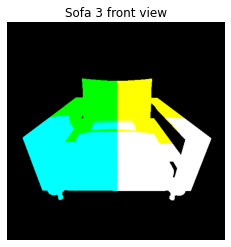

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_03.obj', torch.tensor([[-0.3196,85.,100.]]),torch.tensor([[0.,-1.,-1.]])))
plt.axis('off')
plt.title('Sofa 3 front view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.4573, 34.5165, -0.3901], device='cuda:0')


Text(0.5, 1.0, 'Sofa 3 right view')

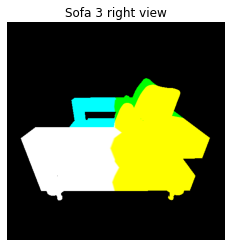

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_03.obj',torch.tensor([[100.,85.,0.]])))
plt.axis('off')
plt.title('Sofa 3 right view')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.4573, 34.5165, -0.3901], device='cuda:0')


Text(0.5, 1.0, 'Sofa 3 left view')

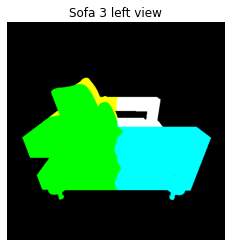

In [ ]:
plt.imshow(render_image_array('/content/drive/MyDrive/render_assignment/sofa_03.obj',torch.tensor([[-100.,85.,0.]])))
plt.axis('off')
plt.title('Sofa 3 left view')